# Détectez les Bad Buzz grâce au Modèle BERT
BERT c'est pour Bidirectional Encoder Representations from Transformers

[Blog BERT](https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente)

[BERT Text Classification](https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d)

[GitHub BERT](https://github.com/google-research/bert)




### Déscriptif projet

<a href="https://openclassrooms.com/fr/paths/188-ingenieur-ia" target="_blank" style="text-decoration: none; text-align:center;">
    
<img src="./Air_Paradis_Logo.png" style="display:inline-block;max-height: 5rem; max-width: 100%;">
</a>


La société "Air Paradis" souhaite pouvoir détecter les bad buzz via le réseau Twitter. 
Elle souhaite pouvoir détecter les sentiments à partir de jeux de données textuels (Prototype à créer)


Jeu de données: Kaggle : <a href="https://www.kaggle.com/kazanova/sentiment140" target="_blank"> "Sentiment140 dataset with 1.6 miilion tweets"</a> 
 - 1.600.000 tweets labellisés avec un sentiment (négatif ou positif). 
 - Génerer plusieurs solutions: Azure, Custom, ...

6 Champs du fichiers: 

    **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
    **id**: The id of the tweet ( 2087)
    **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    **flag*: The query (lyx). If there is no query, then this value is NO_QUERY.
    **user**: the user that tweeted (robotickilldozr)
    **text**: the text of the tweet (Lyx is cool)

Dans ce notebook, nous allons utiliser Keras pour créer et entraîner un réseau neuronal qui analyse les sentiments exprimés.

__Données:__

Nous allons utiliser le même jeu de données que sur le notebook précedent (Modèles Simple et Avancé).

__Traitement des données:__

Nous adapterons le pre-processing des données afin qu'il rende notre modèle BERT le plus performant possible.
Nous évaluerons ainsi plusieurs méthode des pré-traitement.

__Modèles de Réseaux de Neurones:__

Nous réaliserons plusieurs technique de plongements de mots, et choisierons le modèle le plus performant.
Nous adapterons les hyperparamètres des modèles d'apprentissage, afin de visualiser les variations des scores.
Nous travaillerons sur le seuil de décisions afin de visualiser les variations des résultats.


Les évaluations des modèles seront faites sur des [metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) provenant de la librairies SickitLearn, tels que:
 - [F1 score](https://en.wikipedia.org/wiki/F1_score) : $\frac{2TP}{2TP + FP + FN} = \frac{2 * precision * recall}{precision + recall}$
 - Recall : $\frac{TP}{TP + FN}$
 - Precision : $\frac{TP}{TP + FP}$
 - Accuracy : $\frac{TP + TN}{Total}$
 - [ROC_AUC](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)
 
Au regard de la matrice de confusion, l'objectif sera de maximiser l'accuracy (=precision). 
 


In [1]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 

# Import custom helper libraries
import os
import sys

from joblib import dump, load

import preprocessor as p

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import datasets
from datasets import load_dataset, Dataset, load_metric

import transformers
#from transformers import 
from transformers import BertTokenizer, AutoTokenizer, DistilBertTokenizerFast, TFBertModel, BertConfig, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, TFTrainer, TFTrainingArguments, TFDistilBertForSequenceClassification, TFAutoModelForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification, CamembertForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup, create_optimizer, pipeline

import torch

C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calling functions
Test_Imported_Functions()

Functions have been properly imported !


### Lecture du fichier

In [3]:
src_path = os.path.abspath(os.path.join("../IA_Project7_Openclassrooms_BadBuzz_DeepLearning"))
if src_path not in sys.path:
    sys.path.append(src_path)

DATA_URL = os.path.join(src_path, "Dataset", "sentiment140", "training.1600000.processed.noemoticon.csv")
DATASET_COLUMNS = ["target", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
# Using Function load_data = pd.read_csv(DATA_URL, nrows=nrows, names=columns)
df = load_formatted_data(DATA_URL, DATASET_ENCODING, DATASET_COLUMNS) #load_data(DATA_URL, nrows, columns)

### REDUCTION DU JEU DE DONNEE POUR LES PHASES DE TESTS
#clean_df = clean_data(df.groupby('target').apply(lambda x: x.sample(frac=0.08))) #clean_data(df)
clean_df = df.sample(frac=0.002, random_state=0)
clean_df = clean_df.drop(['date', 'flag', 'user'], axis=1)
clean_df.set_index('id',inplace = True)

#clean_df.index.name = 'ids'

#Replace Target value related to positive statement = 1 (Binary reason)
clean_df.loc[clean_df['target'] == 4, 'target'] = 1

#Technique 2 : Text preprocess using https://pypi.org/project/tweet-preprocessor/
clean_df.text = clean_df.text.apply(lambda x: p.clean(x))


In [4]:
clean_df[:1]

,target,text
id,,
2204444171,0,wants to compete! i want hard competition! i w...


In [5]:
# Datasets can read a dataset made up of one or several CSV files:
#dataset = load_dataset('csv', data_files=DATA_URL)

# Load Pandas DataFrames with Dataset.from_pandas() to match with HuggingFace librairies
dataset = Dataset.from_pandas(clean_df)
#dataset = Dataset.from_pandas(clean_df, split='train[:10%]')

In [6]:
# Rename column
dataset = dataset.rename_column("target", "labels")

# Remove column
dataset = dataset.remove_columns("id")

In [7]:
# Creates train and test splits
# https://huggingface.co/docs/datasets/process#split
dataset = dataset.train_test_split(test_size=0.2)

In [8]:
dataset['train'][0]

{'labels': 1, 'text': 'everybody knows this Norman Wisdom thing, come on guys'}

### Préparation des modèles et de la table de résultats

In [4]:
#Initialisation de la table des résultats
score_column_names = ["Model Type","Model Name","seuil","F1-Score","FBeta-Score", "Recall_score", "Precision_score", "Accuracy_score", "Roc_AUC_score"]
store_score = pd.DataFrame(columns = score_column_names)

## Text Classification using BERT HuggingFace transfromers

[Documentation ici](https://huggingface.co/docs/transformers/tasks/sequence_classification#preprocess)

Ici, nous allons utiliser le tokenizer "transformers" pour processer le texte. Nous incluons une strategie de padding et de tronquage pour mieux gérer kes différences de longueures de texte.



#### Preprocess

Nous chargeons le [tokenizer DistilBERT](https://huggingface.co/docs/transformers/tasks/sequence_classification#preprocess) pour processer les champs texte.

Le Tokenizer sera en charge de pré-traiter le texte dans un format compatible au modèle.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

# Load the DistilBERT tokenizer to process the text field:
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
#bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
#auto_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [6]:
# preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length
def preprocess_function(dataset):
    return tokenizer(dataset["text"], truncation=True, padding=True) #'max_length', return_tensors="tf"

#Set the padding parameter to True to pad the shorter sequences in the batch to match the longest sequence:
#Set the truncation parameter to True to truncate a sequence to the maximum length accepted by the model

In [12]:
tokenized_sentiment = dataset.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x000001F1B30920D0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 1/1 [00:00<00:00, 27.42ba/s]


In [13]:
#Apply function on text, we just use the map method of our dataset objec, and return ['labels', 'text', 'input_ids', 'attention_mask']
tokenized_sentiment

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2560
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 640
    })
})

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 2560
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 640
    })
})

In [15]:
#tf_tokenized_sentiment = dataset.map(tf_preprocess_function, batched=True)

In [7]:
#  DataCollatorWithPadding to create a batch of examples
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#data_collator_tf = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

#### Training hyperparameters (Phase décrite dans How-To-Guides)

Nous crééons les Arguments du modèle d'entrainement, qui contiennts les hyperparamètres à ajuster, ainsi que les drapeaux pour activer les options.

Ici, nous commenceons avec les [default training hyperparameters](https://huggingface.co/docs/transformers/training#training-hyperparameters).

Nous spécifions également le dossier de stockage **des checkpoints = ./bert_results/**

In [8]:
# Define your training hyperparameters in TrainingArguments.
training_args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)



### Train the Models on small datasets
#### Train the model 1 : AutoModel ForSequenceClassification - "bert-base-uncased"

Ici, nous utilisons la class trainer pour optimiser l'[entrainement de notre modèle transformers](https://huggingface.co/docs/transformers/training#train).

Nous chargeons notre modèle et nous spécifions le nombre de label attendus (Ici 2 = 0 ou 1)


In [80]:
# Load BERT with AutoModelForSequenceClassification along with the number of expected labels:
model_bert1 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Trainer

Créer un objet Trainer avec notre modèle, nos arguments et nos datasets et fonctions d'évaluation.

In [19]:
# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer1 = Trainer(
    model=model_bert1,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



In [20]:
trainer1.train()

Step,Training Loss
500,0.504600
1000,0.266600
1500,0.115000


TrainOutput(global_step=1600, training_loss=0.28231344521045687, metrics={'train_runtime': 413.3238, 'train_samples_per_second': 3.871, 'total_flos': 30448752467136.0, 'epoch': 5.0})

#### Predict
La sortie de la commande predict est un Tuple contenant 3 champs: predictions, label_ids, and metrics.

[Refer to HuggingFace doc](https://huggingface.co/course/chapter3/3?fw=pt#evaluation)

La prédiction est un tableau à 2 dimensions. Nous devons prendre l'index avec la valeur maximum du 2eme axes.

In [21]:
y_prob = trainer1.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
y_pred


array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,

In [22]:
print(y_prob.predictions.shape, y_prob.label_ids.shape)

(640, 2) (640,)


In [23]:
y_prob[2]

{'test_loss': 1.0828139781951904,
 'test_runtime': 4.7965,
 'test_samples_per_second': 133.432}

In [24]:
y_prob[0][:10]

array([[ 3.4468405, -3.3625178],
       [ 2.4050932, -1.7850631],
       [-3.2621017,  3.2751007],
       [-2.5521908,  2.632381 ],
       [-1.0905306,  1.2925358],
       [-3.0590928,  3.024086 ],
       [ 3.0262783, -2.8779526],
       [ 3.5097845, -3.367872 ],
       [-3.1300006,  3.031073 ],
       [-3.5851698,  3.451444 ]], dtype=float32)

In [25]:
y_prob[1][:10]

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int64)

In [26]:
y_pred[:10]

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int64)

In [27]:
tokenized_sentiment["test"]["labels"][:10]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1]

In [28]:
#tokenized_sentiment["test"][:10]

In [29]:
trainer1.evaluate(tokenized_sentiment["test"])

{'eval_loss': 1.0828139781951904,
 'eval_runtime': 4.4936,
 'eval_samples_per_second': 142.426,
 'epoch': 5.0}

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_prob[1], y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       318
           1       0.77      0.81      0.79       322

    accuracy                           0.78       640
   macro avg       0.78      0.78      0.78       640
weighted avg       0.78      0.78      0.78       640



In [31]:
y_test = dataset["test"]["labels"]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_prob[1], y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
Roc_AUC_score

0.782657525684597

In [32]:
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

In [33]:
model_name="1. BERT AutoModel - bert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

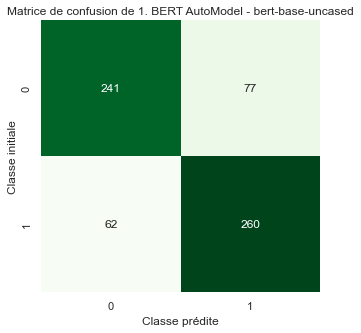

In [34]:
#Plot functions
matrix_pred_model(model_bert1, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)
    

In [35]:

score_results = pd.Series([model_bert1, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


In [36]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,BertForSequenceClassification(\n (bert): Bert...,1. BERT AutoModel - bert-base-uncased,0.5,0.789074,0.778443,0.807453,0.771513,0.782813,0.782658


#### Train the model 2 : AutoModel ForSequenceClassification - "distilbert-base-uncased"


In [37]:
# Load BERT with AutoModelForSequenceClassification along with the number of expected labels:
model_bert2 = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [38]:
# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer2 = Trainer(
    model=model_bert2,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


In [39]:
trainer2.train()

Step,Training Loss
500,0.475800
1000,0.256500
1500,0.110900


TrainOutput(global_step=1600, training_loss=0.26878271222114564, metrics={'train_runtime': 223.1634, 'train_samples_per_second': 7.17, 'total_flos': 18627419422080.0, 'epoch': 5.0})

In [40]:
y_prob = trainer2.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
y_pred

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,

In [41]:
model_name="2. BERT AutoModel - distilbert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_prob[1], y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

score_results = pd.Series([model_bert2, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,BertForSequenceClassification(\n (bert): Bert...,1. BERT AutoModel - bert-base-uncased,0.5,0.790123,0.788663,0.79257,0.787692,0.7875,0.787452
1,DistilBertForSequenceClassification(\n (disti...,2. BERT AutoModel - distilbert-base-uncased,0.5,0.774295,0.780164,0.764706,0.784127,0.775,0.775097


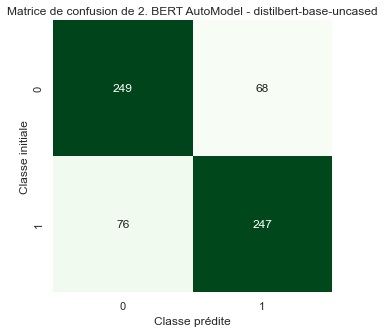

In [42]:
#Plot functions
matrix_pred_model(model_bert2, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)
    

#### Train the model 3 :Roberta ForSequenceClassification - "bert-base-uncased"

In [16]:
# Load BERT with AutoModelForSequenceClassification along with the number of expected labels:
model_bert3 = RobertaForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing RobertaForSequenceClassification: ['bert.encoder.layer.3.attention.self.key.weight', 'bert.encoder.layer.3.output.dense.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.2.output.dense.bias', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.9.intermediate.dense.bias', 'bert.encoder.layer.4.intermediate.dense.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.6.intermediate.dense.weight', 'bert.encoder.layer.7.attention.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.output.LayerNorm.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'bert.encoder.layer.4.attention.output.dense.weight', 'bert.encoder.layer.2.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.3.intermediate.dense.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.3.output.dense.weight', 'encoder.layer.11.intermediate.dense.weight', 'encoder.layer.3.attention.self.key.bias', 'encoder.layer.4.attention.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.4.output.LayerNorm.weight', 'encoder.layer.6.intermediate.dense.weight', 'encoder.layer.5.output.LayerNorm.

In [19]:
# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer3 = Trainer(
    model=model_bert3,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [20]:
trainer3.train()

Step,Training Loss
500,0.712600
1000,0.686900
1500,0.611600


TrainOutput(global_step=1600, training_loss=0.6639623999595642, metrics={'train_runtime': 410.2222, 'train_samples_per_second': 3.9, 'total_flos': 30448752467136.0, 'epoch': 5.0})

In [21]:
y_prob = trainer3.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
y_pred

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,

In [26]:
model_name="3. ROBERTA - bert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_prob[1], y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

score_results = pd.Series([model_bert3, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,RobertaForSequenceClassification(\n (roberta)...,3. ROBERTA - bert-base-uncased,0.5,0.660767,0.658436,0.664688,0.656891,0.640625,0.639275


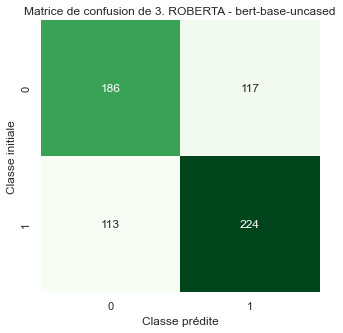

In [27]:
#Plot functions
matrix_pred_model(model_bert3, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)
    

#### Train the model 4 :Camembert ForSequenceClassification - "distilbert-base-uncased"

In [15]:
# Load BERT with AutoModelForSequenceClassification along with the number of expected labels:
model_bert4 = CamembertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


You are using a model of type bert to instantiate a model of type camembert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing CamembertForSequenceClassification: ['bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.3.attention.self.query.bias', 'bert.encoder.layer.7.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.4.intermediate.dense.weight', 'bert.encoder.layer.11.output.LayerNorm.bias', 'bert.encoder.layer.7.attention.output.dense.bias', 'bert.encoder.layer.7.attention.self.key.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.4.attention.output.LayerNorm.bias', 'bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.5.att

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['encoder.layer.5.attention.self.query.bias', 'encoder.layer.8.attention.output.dense.weight', 'encoder.layer.5.attention.self.query.weight', 'encoder.layer.10.attention.self.query.bias', 'encoder.layer.8.intermediate.dense.bias', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.0.intermediate.dense.weight', 'classifier.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.1.attention.output.LayerNorm.bias', 'encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.4.attention.self.value.bias', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.l

In [16]:
# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer4 = Trainer(
    model=model_bert4,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [17]:
trainer4.train()

Step,Training Loss
500,0.718800
1000,0.680200
1500,0.539900


TrainOutput(global_step=1600, training_loss=0.6363067865371704, metrics={'train_runtime': 409.1323, 'train_samples_per_second': 3.911, 'total_flos': 29938995996768.0, 'epoch': 5.0})

In [18]:
y_prob = trainer4.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
y_pred

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,

In [19]:
model_name="4. CAMEMBERT - bert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_prob[1], y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

score_results = pd.Series([model_bert4, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,CamembertForSequenceClassification(\n (robert...,4. CAMEMBERT - bert-base-uncased,0.5,0.702128,0.698307,0.708589,0.695783,0.69375,0.693466


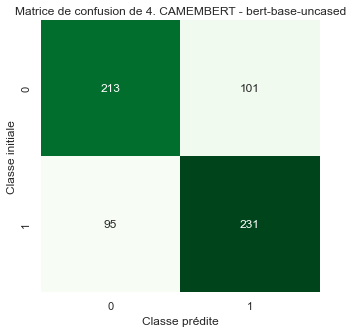

In [20]:
#Plot functions
matrix_pred_model(model_bert4, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)

Le modèle le plus performant après fine tuning est le modèle BERT (Model 1).
Nous allons ré-exécuter son entraînement en 2 étapes:
 1. En mesurant Loss et Accuracy au cours de l'entrainement.
 2. Sur une base de données plus importante, et évaluer son gain de performance.


#### Training hyperparameters (Phase décrite dans Tutorial, avec la mesure des Métriques au cours de l'entrainement)

Nous crééons les Arguments du modèle d'entrainement, qui contiennts les hyperparamètres à ajuster, ainsi que les drapeaux pour activer les options.

Ici, nous commenceons avec les [default training hyperparameters](https://huggingface.co/docs/transformers/training#training-hyperparameters).

Nous spécifions également le dossier de stockage **des checkpoints = ./bert_results/**

[Voir Notebook Colab ici](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=H63Y-TjyRC7S)

[Voir Training ici](https://huggingface.co/docs/transformers/training)

In [16]:
# create a TrainingArguments class which contains all the hyperparameters you can tune as well as flags for activating different training options.
# monitor your evaluation metrics during fine-tuning, specify the evaluation_strategy parameter in your training arguments 
#training_args = TrainingArguments(output_dir="./bert_results/", evaluation_strategy="epoch")

training_args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    eval_accumulation_steps=1,
    
    #--use_ipex,
    #--bf16,
    #--no_cuda
    #warmup_steps=500,                # number of warmup steps for learning rate scheduler
    #logging_steps=100,
)

In [17]:
# need to pass Trainer a function to compute and report metrics
metric = load_metric("accuracy")

In [18]:
# Call compute on metric to calculate the accuracy of your predictions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
# Load BERT with AutoModelForSequenceClassification along with the number of expected labels:
model_bert1 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:

# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer = Trainer(
    model=model_bert1,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.380415,0.770312
2,0.086900,1.392268,0.775000
3,0.086900,1.468110,0.801562
4,0.053900,1.621447,0.789062
5,0.019400,1.545250,0.798438
6,0.019400,1.584323,0.793750
7,0.036600,1.771250,0.787500
8,0.002900,1.852216,0.789062
9,0.002900,1.890177,0.789062
10,0.005000,1.901506,0.789062


TrainOutput(global_step=3200, training_loss=0.032194600198417904, metrics={'train_runtime': 869.9545, 'train_samples_per_second': 3.678, 'total_flos': 60897504934272.0, 'epoch': 10.0})

In [42]:
y_prob = trainer.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
#y_pred

In [44]:
model_name="1. BERT measure metrics - bert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_prob[1], y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

score_results = pd.Series([model_bert1, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,BertForSequenceClassification(\n (bert): Bert...,1. BERT AutoModel - bert-base-uncased,0.5,0.789074,0.778443,0.807453,0.771513,0.782813,0.782658
1,BertForSequenceClassification(\n (bert): Bert...,1. BERT measure metrics - bert-base-uncased,0.5,0.791988,0.788344,0.798137,0.785933,0.789062,0.789005


In [45]:
print(classification_report(y_prob[1], y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       318
           1       0.79      0.80      0.79       322

    accuracy                           0.79       640
   macro avg       0.79      0.79      0.79       640
weighted avg       0.79      0.79      0.79       640



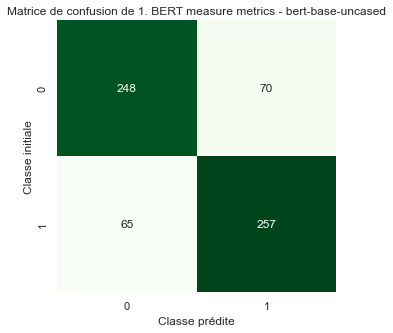

In [47]:
#Plot functions
matrix_pred_model(model_bert1, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)

### Train the Models on large datasets
#### Train the model 1 : AutoModel ForSequenceClassification - "bert-base-uncased"

In [ ]:
# Load BERT with AutoModelForSequenceClassification along with the number of expected labels:
model_bert1 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [9]:
### AUGMENTATION DU JEU DE DONNEE POUR LES PHASES DE TESTS
#clean_df = clean_data(df.groupby('target').apply(lambda x: x.sample(frac=0.08))) #clean_data(df)
clean_df = df.sample(frac=0.05, random_state=0)
clean_df = clean_df.drop(['date', 'flag', 'user'], axis=1)
clean_df.set_index('id',inplace = True)

#clean_df.index.name = 'ids'

#Replace Target value related to positive statement = 1 (Binary reason)
clean_df.loc[clean_df['target'] == 4, 'target'] = 1

#Technique 2 : Text preprocess using https://pypi.org/project/tweet-preprocessor/
clean_df.text = clean_df.text.apply(lambda x: p.clean(x))


In [10]:
dataset2 = Dataset.from_pandas(clean_df)
# Rename column
dataset2 = dataset2.rename_column("target", "labels")

# Remove column
dataset2 = dataset2.remove_columns("id")
dataset2 = dataset2.train_test_split(test_size=0.2)

In [11]:
tokenized_sentiment = dataset2.map(preprocess_function, batched=True)
tokenized_sentiment

Parameter 'function'=<function preprocess_function at 0x000001F9D7AEEEE0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 16/16 [00:00<00:00, 17.50ba/s]


DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 64000
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
})

In [20]:
# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer5 = Trainer(
    model=model_bert1,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [21]:
trainer5.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.393300,0.395987,0.839938
2,0.312800,0.488385,0.839375
3,0.188600,0.695894,0.840250


TrainOutput(global_step=24000, training_loss=0.31803808943430584, metrics={'train_runtime': 7993.2865, 'train_samples_per_second': 3.003, 'total_flos': 0, 'epoch': 3.0})

In [22]:
y_prob = trainer5.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
#y_pred

In [23]:
model_name="1. BERT large datasets - bert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_prob[1], y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

score_results = pd.Series([model_bert1, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,BertForSequenceClassification(\n (bert): Bert...,1. BERT large datasets - bert-base-uncased,0.5,0.841341,0.837659,0.847549,0.835223,0.84025,0.840254


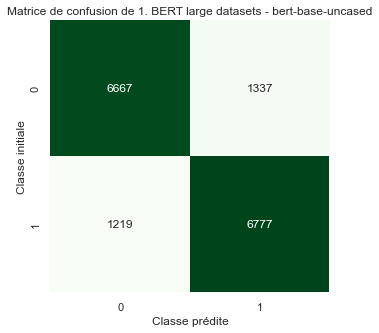

In [24]:
#Plot functions
matrix_pred_model(model_bert1, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)

In [30]:
dump(model_bert1, './Models/model_bert1.joblib')

['./Models/model_bert1.joblib']

In [28]:
#save tokenizer in joblib files
dump(tokenizer, './Models/bert_tokenizer.joblib')

['./Models/bert_tokenizer.joblib']

## Test du modèle sur une entrée manuelle

In [32]:
test_text = ["We are very happy to test the great transformers library.", "We are very frustrated to see how complex it is."]

test_text_series = pd.Series(test_text)
test_text_df = pd.DataFrame(test_text_series,  columns = ['text'])
test_text_dict = datasets.Dataset.from_pandas(test_text_df)
tokenized_test_text_dict = test_text_dict.map(preprocess_function, batched=True)

test_text_encoding = tokenizer(test_text)
print(test_text_encoding)



100%|██████████| 1/1 [00:00<00:00, 133.96ba/s]

{'input_ids': [[101, 2057, 2024, 2200, 3407, 2000, 3231, 1996, 2307, 19081, 3075, 1012, 102], [101, 2057, 2024, 2200, 10206, 2000, 2156, 2129, 3375, 2009, 2003, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [62]:
tokenized_test_text_dict

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2
})

In [63]:
y_prob_test = trainer5.predict(tokenized_test_text_dict) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob_test.predictions, axis=-1)
y_pred

array([1, 0], dtype=int64)

In [33]:
test_text

['We are very happy to test the great transformers library.',
 'We are very frustrated to see how complex it is.']

In [64]:
pipe = pipeline("text-classification")

pipe(test_text)

[{'label': 'POSITIVE', 'score': 0.9997225999832153},
 {'label': 'NEGATIVE', 'score': 0.9996737241744995}]

In [74]:
clean_test_text = test_text_series.apply(lambda x: p.clean(x))
clean_test_text.tolist()
pipe(clean_test_text.tolist())

[{'label': 'POSITIVE', 'score': 0.9997225999832153},
 {'label': 'NEGATIVE', 'score': 0.9996737241744995}]

In [75]:
clean_test_text.tolist()

['We are very happy to test the great transformers library.',
 'We are very frustrated to see how complex it is.']